# Forecasting Energy demand With Machine Learning

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap
shap.initjs()

# Warnings configuration + Script reload
# ==============================================================================
import warnings
import importlib
warnings.filterwarnings('once')

## Introduction

Ce Notebook a pour but de prédire la demande d'énergie à l'heure en utilisant des modèles de machine learning. Les données utilisées sont celles de la consommation d'électricité de Melbourne (fréquence de 30 minutes) en Australie de 2012 à 2014. Plusieurs stratégies seront passés en revues, allant de stratégies naïves à des stratégies plus complexes qui prennent en considération des variables exogènes et des modèles non linéaires (Gradient Boosting). 

In [2]:
# Data download
# ==============================================================================
data = pd.read_csv(filepath_or_buffer='data/vic_elec.csv', index_col=0, parse_dates=True)
data.index = pd.to_datetime(data.index, utc=True, format='%Y-%m-%d %H:%M:%S')
data.head()

Demand  Temperature     Date  Holiday
Time                                                                 
2011-12-31 13:00:00+00:00  4382.825174        21.40  15340.0     True
2011-12-31 13:30:00+00:00  4263.365526        21.05  15340.0     True
2011-12-31 14:00:00+00:00  4048.966046        20.70  15340.0     True
2011-12-31 14:30:00+00:00  3877.563330        20.55  15340.0     True
2011-12-31 15:00:00+00:00  4036.229746        20.40  15340.0     True

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2011-12-31 13:00:00+00:00 to 2014-12-31 12:30:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       52608 non-null  float64
 1   Temperature  52608 non-null  float64
 2   Date         52608 non-null  float64
 3   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(3)
memory usage: 1.7 MB


In [4]:
data = data.asfreq('30min')
data.index

DatetimeIndex(['2011-12-31 13:00:00+00:00', '2011-12-31 13:30:00+00:00',
               '2011-12-31 14:00:00+00:00', '2011-12-31 14:30:00+00:00',
               '2011-12-31 15:00:00+00:00', '2011-12-31 15:30:00+00:00',
               '2011-12-31 16:00:00+00:00', '2011-12-31 16:30:00+00:00',
               '2011-12-31 17:00:00+00:00', '2011-12-31 17:30:00+00:00',
               ...
               '2014-12-31 08:00:00+00:00', '2014-12-31 08:30:00+00:00',
               '2014-12-31 09:00:00+00:00', '2014-12-31 09:30:00+00:00',
               '2014-12-31 10:00:00+00:00', '2014-12-31 10:30:00+00:00',
               '2014-12-31 11:00:00+00:00', '2014-12-31 11:30:00+00:00',
               '2014-12-31 12:00:00+00:00', '2014-12-31 12:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=52608, freq='30min')

In [5]:
data.head(2)

Demand  Temperature     Date  Holiday
Time                                                                 
2011-12-31 13:00:00+00:00  4382.825174        21.40  15340.0     True
2011-12-31 13:30:00+00:00  4263.365526        21.05  15340.0     True

In [6]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


La colonne `Date`n'ajoute pas d'information supplémentaire par rapport à la colonne `Time`, on peut s'en débarasser. 
Également, nous souhaitons prédire la demande d'énergie à l'heure, il est donc essentiel d'aggréger les données à l'heure en évitant tout biais de `forward looking`.
Pour cela, nous allons prendre la moyenne des valeurs de 11h et 11h30 pour obtenir la aggrégé de 12h, etc.. 

In [7]:
data.drop(columns=['Date'], inplace=True)
data = data.resample(rule='h', closed='left', label='right').mean()
data.head()

Demand  Temperature  Holiday
Time                                                        
2011-12-31 14:00:00+00:00  4323.095350       21.225      1.0
2011-12-31 15:00:00+00:00  3963.264688       20.625      1.0
2011-12-31 16:00:00+00:00  3950.913495       20.325      1.0
2011-12-31 17:00:00+00:00  3627.860675       19.850      1.0
2011-12-31 18:00:00+00:00  3396.251676       19.025      1.0

Préparation des différents jeux de données pour l'entrainement, la validation et le test.

In [8]:
# Split data into train-val-test
# ==============================================================================
from utils import split_data

end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data, data_train, data_val, data_test = split_data(data, end_train, end_validation)

Train dates      : 2012-01-01 00:00:00+00:00 --- 2013-12-31 23:00:00+00:00  (n=17544)
Validation dates : 2014-01-01 00:00:00+00:00 --- 2014-11-30 23:00:00+00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00+00:00 --- 2014-12-30 23:00:00+00:00  (n=720)


In [9]:
# Interactive plot of time series
# ==============================================================================
from utils import plot_interactive_time_series

plot_interactive_time_series(data_train, data_val, data_test)

On peut dors et déjà observer que la demande d'électricité possède une saisonnalité annuelle, avec des pics de consommation de janvier à mars et de juillet à septembre.

/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



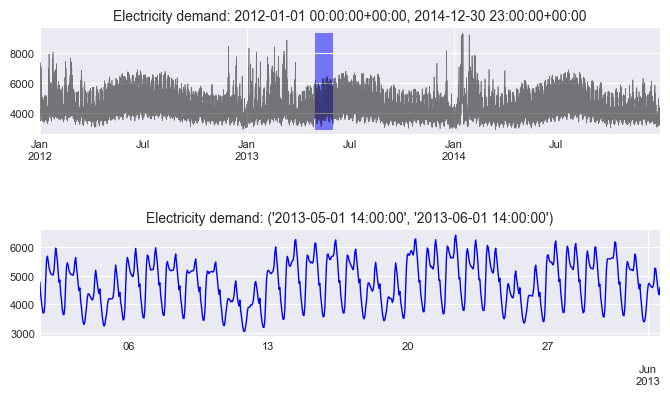

In [10]:
from utils import plot_zoomed_time_series

zoom_range = ('2013-05-01 14:00:00', '2013-06-01 14:00:00')
plot_zoomed_time_series(data, zoom_range)

En zoomant sur la série temporelle, on peut également observer une saisonnalité hebdomadaire, avec une plus grande consommation durant les jours de semaine par rapport aux week-ends.
On peut également observer une corrélation claire entre la consommation du jour et celle du jour qui précède. 

## Graphiques de saisonnalité

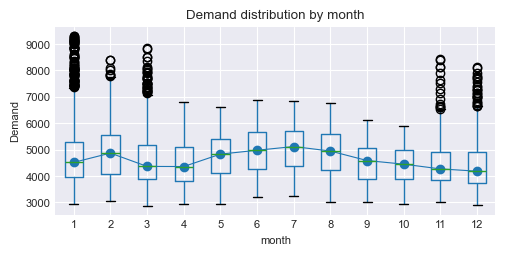

In [11]:
# Demand distribution by month
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['month'] = data.index.month
data.boxplot(column='Demand', by='month', ax=ax,)
data.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('')
plt.show()

On peut observer à l'échelle annuelle qu'il y a des valeurs plus extrêmes de consommation en hiver, avec une plus grande stabilité en été. 
Également, la saisonnalité mensuelle est encore uen fois apparente, avec des mois de juin à août possédant une consommation médiane plus élevée que les autres mois. 

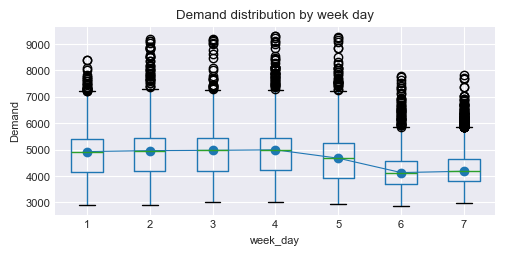

In [12]:
# Demand distribution by week day
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Demand', by='week_day', ax=ax)
data.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('')
plt.show()

La saisonnalité hebdomadaire est également apparente, avec une consommation plus élevée en semaine par rapport aux week-ends.

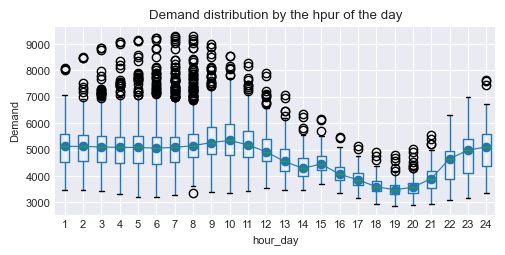

In [13]:
# Demand distribution by the hour of the day
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['hour_day'] = data.index.hour + 1
data.boxplot(column='Demand', by='hour_day', ax=ax)
data.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by the hpur of the day')
fig.suptitle('')
plt.show()

Enfin, on peut observer une saisonnalité journalière, avec une consommation plus élevée en début de journée, des heures plus creuses de 16h à 20h et une augmentation de la consommation en soirée.

## Graphiques d'autocorrélation

Les graphiques d'autocorrélation sont essentiels pour déterminer l'ordre d'un modèle autorégressif. La fonction d'autocorrélation (ACF) mesure la corrélation entre une série temporelle et ses valeurs décalées, révélant les dépendances linéaires. La fonction d'autocorrélation partielle (PACF) quantifie cette corrélation tout en contrôlant les lags intermédiaires, isolant ainsi les relations directes. En examinant les plots ACF et PACF, on identifie les lags pertinents à inclure dans le modèle. Par exemple, une ACF élevée à un lag particulier indique une forte corrélation, tandis qu'une PACF significative à un lag révèle une relation directe après contrôle des autres lags. Ces outils permettent de sélectionner les lags optimaux pour une modélisation autorégressive précise.

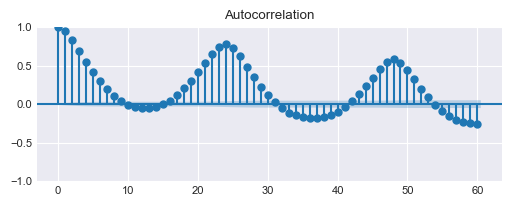

In [14]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2))
plot_acf(data.Demand, ax=ax, lags=60)
plt.show()

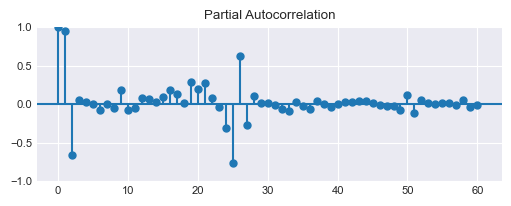

In [15]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2))
plot_pacf(data.Demand, ax=ax, lags=60)
plt.show()

Les graphiques d'autocorrélation démontrent une forte corrélation entre la demande à une certaine heure et les heures précédentes. Ce phénomène est également observable avec les heures de la journée précédente. Cette observation suggère que les modèles auto régressifs pourraient être appropriés pour la prédiction de la demande d'énergie.

## Modèle de Prédiction Naïf (Baseline)

Le modèle de prédiction naïf est une méthode simple qui prédit la valeur de la demande à l'heure actuelle en utilisant la valeur de la même heure du jour précédent.

In [16]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data_test['Demand'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2014-12-01 00:00:00+0000', tz='UTC'), Timestamp('2014-12-30 23:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2024-07-25 10:54:45 
Last fit date: 2024-07-25 10:54:45 
Skforecast version: 0.12.1 
Python version: 3.12.2 
Forecaster id: None 

In [17]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric}")

  0%|          | 0/30 [00:00<?, ?it/s]

Backtest error (MAE): 308.3752715958334


In [18]:
from utils import plot_predictions_vs_real

plot_predictions_vs_real(data_test, predictions)

Résultats qui confirme notre théorie sur la corrélation entre la demande d'énergie à une certaine heure et la même heure du jour précédent. En effet, les prédictions sont raisonnables pour un modèle naïf, ce qui est encourageant pour des modèles plus complexes.

## Multi Step Forecasting avec Récursion

On peut maintenant essayer un modèle plus complexe avec le `LightGBMRegressor` pour prédire la demande d'énergie. L'approche est récursive, c'est à dire que l'on garde le même modèle entrainé sur les données d'entrainement pour prédire les 24 prochaines heures en utilisant les dernières 24 heures comme lags prédicteurs.  

In [19]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00+0000', tz='UTC'), Timestamp('2014-11-30 23:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq':

In [20]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:00:00+00:00  (n=25560)
    Validation: 2014-12-01 00:00:00+00:00 -- 2014-12-01 23:00:00+00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:00:00+00:00  (n=25560)
    Validation: 2014-12-02 00:00:00+00:00 -- 2014-12-02 23:00:00+00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:00:00+00:00  (n=25560)
    Validation: 2014-12-03 00:00:00+00:00 -- 2014-12-03 23:00:00+00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00+00:00 -- 2014-11-30 23:00:00+00:00  (n=25560)
    Validation: 2014-12-04 00:00:00+00:00 -- 2014-12-04 23:00:00+00:00  (n=24)
Fold: 4


  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
plot_predictions_vs_real(data_test, predictions)

C'est mieux mais le modèle n'est pas `fine tune` à nos données. Voyons comment on peut améliorer les prédictions en ajustant les paramètres du modèle par une approche de validation croisée. 

## Recherche des meilleurs Hyperparamètres

Nous sélectionnons une approche Bayesienne afin de sélectionner les meilleurs hyperparamètres pour notre modèle. Le `forecatser` renvoyé par la recherche sera celui possédant les meilleurs hyperparamètres car l'argument `return_best` à été sélectionné sur `True`.

In [22]:
# Hyperparameters search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24, # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.loc[:end_validation, 'Demand'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   initial_train_size = len(data[:end_train]),
                                   refit              = False,
                                   n_trials           = 20, # Increase for more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 47, 48, 49) which is of type tuple.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.07767098087794957, 'reg_alpha': 0.5, 'reg_lambda': 0.7000000000000001}
  Backtesting metric: 235.6123970139017



In [23]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.07767098087794957, max_depth=9, n_estimators=1100,
              random_state=123, reg_alpha=0.5, reg_lambda=0.7000000000000001,
              verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00+0000', tz='UTC'), Timestamp('2014-11-30 23:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.07767098087794957, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1100, 'n_jobs': None, 'num_l

In [24]:
results_search.head(10)

lags  \
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
16  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
18                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   

                                               params  mean_absolute_error  \
17  {'n_estimators': 1100, 'max_depth': 9, 'learni...           235.612397   
4   {'n_estimators': 800, 'max_depth': 8, 'learnin...           237.855967   
1   {'n_estimators': 1000, 'max_depth': 6, 'learni...           239.635156   
15  {'n_estimators': 900, 'max_depth': 10, 'learni...           239.716235   
14  {'n_estimators': 700, 'max_depth': 5, 'learnin...           244.464263   
10  {'n_estimators': 600, 'max_depth': 10, 'learni...           244.499025   
11  {'n_estimators': 1200, 'max_depth': 4, 'learni...           250.617539   
16  {'n_estimators': 1200, 'max_depth': 5, 'learni...           255.561203   
13  {'n_estimators': 900, 'max_depth': 7, 'learnin...           256.028143   
18  {'n_estimators': 1100, 'max_depth': 9, 'learni...           256.965555   

    n_estimators  max_depth  learning_rate  reg_alpha  reg_lambda  
17        1100.0        9.0       0.077671        0.5         0.7  
4          800.0        8.0       0.055131        0.4         0.4  
1         1000.0        6.0       0.202138        0.3         0.8  
15         900.0       10.0       0.173305        0.4         0.8  
14         700.0        5.0       0.145675        0.0         0.3  
10         600.0       10.0       0.205234        0.4         0.0  
11        1200.0        4.0       0.218910        0.3         1.0  
16        1200.0        5.0       0.288489        0.3         0.3  
13         900.0        7.0       0.321041        0.3         0.8  
18        1100.0        9.0       0.067970        0.8         0.6

In [25]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()

  0%|          | 0/30 [00:00<?, ?it/s]

Backtest error: 206.23


pred
2014-12-01 00:00:00+00:00  5592.178840
2014-12-01 01:00:00+00:00  5562.546052
2014-12-01 02:00:00+00:00  5535.704966
2014-12-01 03:00:00+00:00  5548.407936
2014-12-01 04:00:00+00:00  5529.362443

In [26]:
plot_predictions_vs_real(data_test, predictions)

Les prédictions sont encore meilleures. Cependant, nous pouvons encore faire mieux en intégrant des variables éexogènes. 

## Variables Exogènes

Jusqu'à présent, seules les valeurs décalées de la série temporelle ont été utilisées comme prédicteurs. Cependant, il est possible d'inclure d'autres variables comme prédicteurs. Ces variables sont connues sous le nom de variables exogènes (features) et leur utilisation peut améliorer la capacité prédictive du modèle. Un point très important à garder à l'esprit est que les valeurs des variables exogènes doivent être connues au moment de la prédiction.

Des exemples courants de variables exogènes sont celles dérivées du calendrier, comme le jour de la semaine, le mois, l'année ou les jours fériés. Les variables météorologiques telles que la température, l'humidité et le vent entrent également dans cette catégorie, tout comme les variables économiques telles que l'inflation et les taux d'intérêt.

In [27]:
import utils
importlib.reload(utils)

<module 'utils' from '/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/utils.py'>

In [28]:


name = "Melbourne"
region = "Australia"
timezone = 'Australia/Melbourne'
latitude = -37.8
longitude = 144.95
exogenous_features = utils.add_exogenous_features(data=data, name=name, region=region, timezone=timezone, latitude=latitude, longitude=longitude)


In [29]:
exogenous_features

month  week_of_year  week_day  hour_day  \
Time                                                                 
2012-01-01 00:00:00+00:00      1            52         7         1   
2012-01-01 01:00:00+00:00      1            52         7         2   
2012-01-01 02:00:00+00:00      1            52         7         3   
2012-01-01 03:00:00+00:00      1            52         7         4   
2012-01-01 04:00:00+00:00      1            52         7         5   
...                          ...           ...       ...       ...   
2014-12-30 19:00:00+00:00     12             1         2        20   
2014-12-30 20:00:00+00:00     12             1         2        21   
2014-12-30 21:00:00+00:00     12             1         2        22   
2014-12-30 22:00:00+00:00     12             1         2        23   
2014-12-30 23:00:00+00:00     12             1         2        24   

                           sunrise_hour  sunset_hour  daylight_hours  \
Time                                                                   
2012-01-01 00:00:00+00:00             6           20              14   
2012-01-01 01:00:00+00:00             6           20              14   
2012-01-01 02:00:00+00:00             6           20              14   
2012-01-01 03:00:00+00:00             6           20              14   
2012-01-01 04:00:00+00:00             6           20              14   
...                                 ...          ...             ...   
2014-12-30 19:00:00+00:00             6           20              14   
2014-12-30 20:00:00+00:00             6           20              14   
2014-12-30 21:00:00+00:00             6           20              14   
2014-12-30 22:00:00+00:00             6           20              14   
2014-12-30 23:00:00+00:00             6           20              14   

                           is_daylight  Temperature  temp_roll_mean_1_day  \
Time                                                                        
2012-01-01 00:00:00+00:00            0       27.000             27.000000   
2012-01-01 01:00:00+00:00            0       29.650             28.325000   
2012-01-01 02:00:00+00:00            0       31.650             29.433333   
2012-01-01 03:00:00+00:00            0       32.675             30.243750   
2012-01-01 04:00:00+00:00            0       32.300             30.655000   
...                                ...          ...                   ...   
2014-12-30 19:00:00+00:00            1       13.000             17.764583   
2014-12-30 20:00:00+00:00            0       12.100             17.702083   
2014-12-30 21:00:00+00:00            0       12.300             17.575000   
2014-12-30 22:00:00+00:00            0       14.050             17.470833   
2014-12-30 23:00:00+00:00            0       16.600             17.402083   

                           temp_roll_mean_7_day  temp_roll_max_1_day  \
Time                                                                   
2012-01-01 00:00:00+00:00             27.000000               27.000   
2012-01-01 01:00:00+00:00             28.325000               29.650   
2012-01-01 02:00:00+00:00             29.433333               31.650   
2012-01-01 03:00:00+00:00             30.243750               32.675   
2012-01-01 04:00:00+00:00             30.655000               32.675   
...                                         ...                  ...   
2014-12-30 19:00:00+00:00             18.567560               23.500   
2014-12-30 20:00:00+00:00             18.548810               23.500   
2014-12-30 21:00:00+00:00             18.533036               23.500   
2014-12-30 22:00:00+00:00             18.518155               23.500   
2014-12-30 23:00:00+00:00             18.506548               23.500   

                           temp_roll_min_1_day  temp_roll_max_7_day  \
Time                                                                  
2012-01-01 00:00:00+00:00                 27.0               27.000   
2012-01-01 01:00:00+00:00  

Certains aspects du calendrier, tels que les heures ou les jours, sont cycliques. Par exemple, le cycle heure-jour va de 0 à 23 heures. Bien qu'interprété comme une variable continue, l'heure 23:00 est à seulement une heure de 00:00. Il en va de même pour le cycle mois-année, puisque décembre est à seulement un mois de janvier. L'utilisation de fonctions trigonométriques telles que les transformations en sinus et cosinus permet de représenter les motifs cycliques et d'éviter les incohérences dans la représentation des données. Cette approche est connue sous le nom de codage cyclique et peut améliorer considérablement la capacité prédictive des modèles.

In [30]:
month_encoded = utils.cyclical_encoding(exogenous_features['month'], cycle_length=12)
week_of_year_encoded = utils.cyclical_encoding(exogenous_features['week_of_year'], cycle_length=52)
week_day_encoded = utils.cyclical_encoding(exogenous_features['week_day'], cycle_length=7)
hour_day_encoded = utils.cyclical_encoding(exogenous_features['hour_day'], cycle_length=24)
sunrise_hour_encoded = utils.cyclical_encoding(exogenous_features['sunrise_hour'], cycle_length=24)
sunset_hour_encoded = utils.cyclical_encoding(exogenous_features['sunset_hour'], cycle_length=24)

cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_day_encoded,
                        sunrise_hour_encoded,
                        sunset_hour_encoded
                    ], axis=1)

exogenous_features = pd.concat([exogenous_features, cyclical_features], axis=1)
exogenous_features.head(3)

month  week_of_year  week_day  hour_day  \
Time                                                                 
2012-01-01 00:00:00+00:00      1            52         7         1   
2012-01-01 01:00:00+00:00      1            52         7         2   
2012-01-01 02:00:00+00:00      1            52         7         3   

                           sunrise_hour  sunset_hour  daylight_hours  \
Time                                                                   
2012-01-01 00:00:00+00:00             6           20              14   
2012-01-01 01:00:00+00:00             6           20              14   
2012-01-01 02:00:00+00:00             6           20              14   

                           is_daylight  Temperature  temp_roll_mean_1_day  \
Time                                                                        
2012-01-01 00:00:00+00:00            0        27.00             27.000000   
2012-01-01 01:00:00+00:00            0        29.65             28.325000   
2012-01-01 02:00:00+00:00            0        31.65             29.433333   

                           ...  week_of_year_sin  week_of_year_cos  \
Time                       ...                                       
2012-01-01 00:00:00+00:00  ...               0.0               1.0   
2012-01-01 01:00:00+00:00  ...               0.0               1.0   
2012-01-01 02:00:00+00:00  ...               0.0               1.0   

                           week_day_sin  week_day_cos  hour_day_sin  \
Time                                                                  
2012-01-01 00:00:00+00:00 -2.449294e-16           1.0      0.258819   
2012-01-01 01:00:00+00:00 -2.449294e-16           1.0      0.500000   
2012-01-01 02:00:00+00:00 -2.449294e-16           1.0      0.707107   

                           hour_day_cos  sunrise_hour_sin  sunrise_hour_cos  \
Time                                                                          
2012-01-01 00:00:00+00:00      0.965926               1.0      6.123234e-17   
2012-01-01 01:00:00+00:00      0.866025               1.0      6.123234e-17   
2012-01-01 02:00:00+00:00      0.707107               1.0      6.123234e-17   

                           sunset_hour_sin  sunset_hour_cos  
Time                                                         
2012-01-01 00:00:00+00:00        -0.866025              0.5  
2012-01-01 01:00:00+00:00        -0.866025              0.5  
2012-01-01 02:00:00+00:00        -0.866025              0.5  

[3 rows x 30 columns]

Dans de nombreux cas, les variables exogènes ne sont pas isolées. Leur effet sur la variable cible dépend plutôt de la valeur d'autres variables. Par exemple, l'effet de la température sur la demande d'électricité dépend de l'heure de la journée. L'interaction entre les variables exogènes peut être capturée par de nouvelles variables obtenues en multipliant les variables existantes entre elles. Ces interactions sont facilement obtenues avec la classe `PolynomialFeatures` de scikit-learn.

In [31]:
# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [
    'month_sin',
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_day_sin',
    'hour_day_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'Temperature',
    'Holiday'
]

poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)


In [32]:
exogenous_features

month  week_of_year  week_day  hour_day  \
Time                                                                 
2012-01-01 00:00:00+00:00      1            52         7         1   
2012-01-01 01:00:00+00:00      1            52         7         2   
2012-01-01 02:00:00+00:00      1            52         7         3   
2012-01-01 03:00:00+00:00      1            52         7         4   
2012-01-01 04:00:00+00:00      1            52         7         5   
...                          ...           ...       ...       ...   
2014-12-30 19:00:00+00:00     12             1         2        20   
2014-12-30 20:00:00+00:00     12             1         2        21   
2014-12-30 21:00:00+00:00     12             1         2        22   
2014-12-30 22:00:00+00:00     12             1         2        23   
2014-12-30 23:00:00+00:00     12             1         2        24   

                           sunrise_hour  sunset_hour  daylight_hours  \
Time                                                                   
2012-01-01 00:00:00+00:00             6           20              14   
2012-01-01 01:00:00+00:00             6           20              14   
2012-01-01 02:00:00+00:00             6           20              14   
2012-01-01 03:00:00+00:00             6           20              14   
2012-01-01 04:00:00+00:00             6           20              14   
...                                 ...          ...             ...   
2014-12-30 19:00:00+00:00             6           20              14   
2014-12-30 20:00:00+00:00             6           20              14   
2014-12-30 21:00:00+00:00             6           20              14   
2014-12-30 22:00:00+00:00             6           20              14   
2014-12-30 23:00:00+00:00             6           20              14   

                           is_daylight  Temperature  temp_roll_mean_1_day  \
Time                                                                        
2012-01-01 00:00:00+00:00            0       27.000             27.000000   
2012-01-01 01:00:00+00:00            0       29.650             28.325000   
2012-01-01 02:00:00+00:00            0       31.650             29.433333   
2012-01-01 03:00:00+00:00            0       32.675             30.243750   
2012-01-01 04:00:00+00:00            0       32.300             30.655000   
...                                ...          ...                   ...   
2014-12-30 19:00:00+00:00            1       13.000             17.764583   
2014-12-30 20:00:00+00:00            0       12.100             17.702083   
2014-12-30 21:00:00+00:00            0       12.300             17.575000   
2014-12-30 22:00:00+00:00            0       14.050             17.470833   
2014-12-30 23:00:00+00:00            0       16.600             17.402083   

                           ...  poly_temp_roll_min_1_day__temp_roll_max_7_day  \
Time                       ...                                                  
2012-01-01 00:00:00+00:00  ...                                        729.000   
2012-01-01 01:00:00+00:00  ...                                        800.550   
2012-01-01 02:00:00+00:00  ...                                        854.550   
2012-01-01 03:00:00+00:00  ...                                        882.225   
2012-01-01 04:00:00+00:00  ...                                        882.225   
...                        ...                                            ...   
2014-12-30 19:00:00+00:00  ...                                        404.300   
2014-12-30 20:00:00+00:00  ...                                        376.310   
2014-12-30 21:00:00+00:00  ...                                        376.310   
2014-12-30 22:00:00+00:00  ...                                        376.310   
2014-12-30 23:00:00+00:00  ...                                        376.310   

                           poly_temp_roll_min_1_day__temp_roll_min_7_day  \
Time                                           

In [33]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = []

# Columns that ends with _sin or _cos are selected
exog_features.extend(exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())

# Columns that start with temp_ are selected
exog_features.extend(exogenous_features.filter(regex='^temp_.*').columns.tolist())

# Columns that start with holiday_ are selected
exog_features.extend(exogenous_features.filter(regex='^holiday_.*').columns.tolist())

# Include original features
exog_features.extend(['Temperature', 'Holiday'])

In [34]:
# Merge target and exogenous variables in the same DataFrame
# ==============================================================================
data = data[['Demand']].merge(
           exogenous_features[exog_features],
           left_index=True,
           right_index=True,
           how='left'
       )

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. Due to holiday_next_day there are missing values at the end.
data = data.dropna()
data = data.astype('float32')

# Split data into train-val-test
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

On utilise les mêmes hyperparamètres que précédemment pour entrainer le modèle avec les variables exogènes.

In [35]:
# Create forecaster
# ==============================================================================
params = {
    'n_estimators': 800,
    'max_depth': 8,
    'learning_rate': 0.0551314,
    'reg_alpha': 0.4,
    'reg_lambda': 0.4,
    'random_state': 15926,
    'verbose': -1
}
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )

In [36]:
# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          exog               = data[exog_features],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()

  0%|          | 0/30 [00:00<?, ?it/s]

Backtest error: 133.61


pred
2014-12-01 00:00:00+00:00  5611.964210
2014-12-01 01:00:00+00:00  5585.617651
2014-12-01 02:00:00+00:00  5585.085596
2014-12-01 03:00:00+00:00  5650.156049
2014-12-01 04:00:00+00:00  5723.722059

In [37]:
plot_predictions_vs_real(data_test, predictions)

On observe une amélioration significative des prédictions en utilisant des variables exogènes. Cela démontre l'importance de l'intégration de ces variables pour améliorer la capacité prédictive des modèles.

## Prédiction d'intervalles

Un intervalle de prédiction définit l'intervalle dans lequel la véritable valeur de la variable cible peut être attendue avec une probabilité donnée. Rob J Hyndman et George Athanasopoulos, dans leur livre Forecasting: Principles and Practice, listent plusieurs façons d'estimer les intervalles de prédiction, dont la plupart nécessitent que les résidus (erreurs) du modèle soient distribués normalement. Si cette hypothèse ne peut pas être retenue, on peut recourir au bootstrap, qui ne nécessite que les résidus soient non corrélés. 

Le code suivant montre comment générer des intervalles de prédiction pour le modèle autorégressif. La fonction `prediction_interval()` est utilisée pour générer les intervalles de prédiction pour chaque étape prédite. Ensuite, la fonction `backtesting_forecaster()` est utilisée pour générer les intervalles de prédiction pour l'ensemble du jeu de test. L'argument interval est utilisé pour spécifier la probabilité de couverture désirée des intervalles de prédiction. Dans ce cas, interval est fixé à [10, 90], ce qui signifie que les intervalles de prédiction sont calculés pour les 10e et 90e percentiles, résultant en une probabilité de couverture théorique de 80%. L'argument `n_boot` est utilisé pour spécifier le nombre d'échantillons bootstrap à utiliser pour estimer les intervalles de prédiction. Plus le nombre d'échantillons est grand, plus les intervalles de prédiction seront précis, mais plus le calcul prendra du temps.

In [38]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )
forecaster.fit(
    y    = data.loc[:end_train, 'Demand'],
    exog = data.loc[:end_train, exog_features]
)

In [39]:
# Predict intervals
# ==============================================================================
# Since the model has been trained with exogenous variables, they must be provided
# for the prediction.
predictions = forecaster.predict_interval(
                  exog     = data.loc[end_train:, exog_features],
                  steps    = 24,
                  interval = [10, 90], 
              )
predictions.head()

pred  lower_bound  upper_bound
2014-01-01 00:00:00+00:00  3673.382401  3643.688542  3711.854582
2014-01-01 01:00:00+00:00  3811.776237  3765.263478  3862.611083
2014-01-01 02:00:00+00:00  3902.418129  3832.074774  3969.011717
2014-01-01 03:00:00+00:00  3961.182054  3872.026827  4017.793685
2014-01-01 04:00:00+00:00  4005.964946  3911.354771  4086.846933

In [40]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'Demand'], # Train + Validation
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 24,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )
residuals = data.loc[predictions_val.index, 'Demand'] - predictions_val['pred']
residuals = residuals.dropna()

  0%|          | 0/334 [00:00<?, ?it/s]

negative    4525
positive    3491
Name: count, dtype: int64


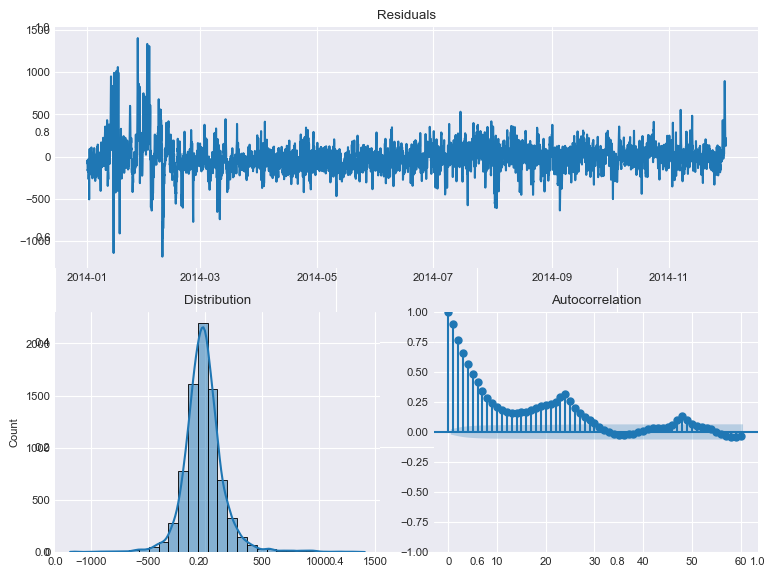

In [41]:
# Out-sample residuals distribution
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
fig, ax = plt.subplots(figsize=(8, 6))
_ = plot_residuals(residuals=residuals, fig=fig)
fig.tight_layout()

In [42]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    residuals = residuals,
    y_pred    = data.loc[predictions_val.index, 'Demand']
)

In [43]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['Demand'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 250,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = True, # Residuals conditioned on predicted values
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

  0%|          | 0/30 [00:00<?, ?it/s]

pred  lower_bound  upper_bound
2014-12-01 00:00:00+00:00  5611.964210  5422.252569  5809.083049
2014-12-01 01:00:00+00:00  5585.617651  5275.263399  6079.649534
2014-12-01 02:00:00+00:00  5585.085596  5164.747609  6550.701569
2014-12-01 03:00:00+00:00  5650.156049  5173.403533  7005.926117
2014-12-01 04:00:00+00:00  5723.722059  5117.052040  7363.294461

In [44]:
utils.plot_prediction_intervals_vs_real(data_test=data_test, predictions=predictions)

In [45]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )
coverage = inside_interval.mean()
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Total area of the interval: 599807.94
Predicted interval coverage: 82.08 %


## Explication des modèles

En raison de la nature complexe de nombreux modèles de machine learning modernes, tels que les méthodes d'ensemble, ils fonctionnent souvent comme des boîtes noires, rendant difficile la compréhension des raisons pour lesquelles une prédiction particulière a été faite. Les techniques d'explicabilité visent à démystifier ces modèles, en fournissant des éclaircissements sur leur fonctionnement interne et en aidant à instaurer la confiance, améliorer la transparence et satisfaire aux exigences réglementaires dans divers domaines. Améliorer l'explicabilité des modèles non seulement aide à comprendre leur comportement, mais permet également d'identifier les biais, d'améliorer les performances du modèle et de permettre aux parties prenantes de prendre des décisions plus éclairées basées sur les informations fournies par le machine learning.

In [46]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'Demand'],
    exog = data.loc[:end_validation, exog_features]
)

In [47]:
# Model-specific feature importances
# ==============================================================================
feature_importances = forecaster.get_feature_importances()
feature_importances.sort_values(by='importance', ascending=False).head(10)

feature  importance
0                                  lag_1        2042
110                          Temperature         992
1                                  lag_2         979
23                                lag_24         917
22                                lag_23         632
2                                  lag_3         625
87       poly_hour_day_sin__hour_day_cos         608
105                  temp_roll_min_1_day         582
69   poly_week_of_year_cos__hour_day_cos         560
31                          hour_day_cos         525

Sans grande surprise, l'heure précédente est la variable la plus importante pour prédire la demande d'énergie, suivit de la température ainsi que du lag 2 et 24. 

In [48]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data_train['Demand'],
                       exog = data_train[exog_features]
                   )

In [49]:
# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=123)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

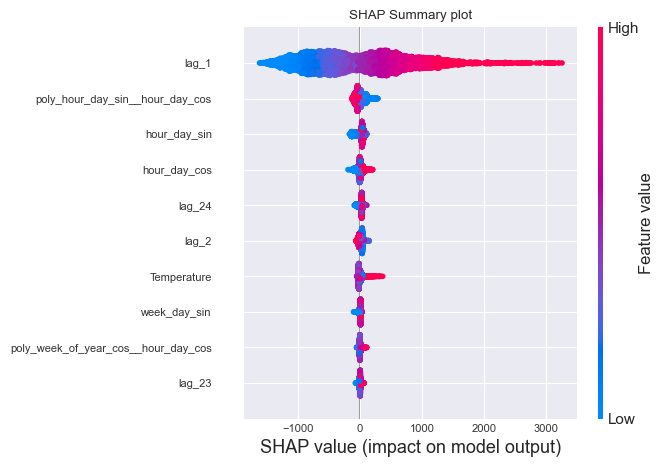

In [50]:
# Shap summary plot (top 10)
# ==============================================================================
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

Pour effectuer une interprétation rapide de ce graphique de SHAP, on peut observer que des valeurs plus élevés du lag 1 sont associés à des valeurs prédites plus élevées de la demande d'énergie. Cette variable à l'impact le plus important sur le modèle. 

In [51]:
# Force plot for the first observation
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_sample.iloc[0,:])

Dans le même esprit, ce graphique démontre les contributions individuelles des variables dans la prédiction de la demande d'énergie pour la première observation. Encore uen fois, le lag 1 à un impact positif signficatif dans la prédiction de la demande d'énergie.

## Sélection de Features

La sélection de caractéristiques est le processus de sélection d'un sous-ensemble de caractéristiques pertinentes pour la construction d'un modèle. C'est une étape importante dans le processus de machine learning, car elle peut aider à réduire le surapprentissage (overfitting), à améliorer la précision du modèle et à réduire le temps d'entraînement. Étant donné que les régresseurs sous-jacents de skforecast suivent l'API de scikit-learn, il est possible d'appliquer les méthodes de sélection de caractéristiques disponibles dans scikit-learn avec la fonction `select_features()`. Deux des méthodes les plus populaires sont l'élimination récursive de caractéristiques (Recursive Feature Elimination) et la sélection séquentielle de caractéristiques (Sequential Feature Selection).

In [52]:
# Create forecaster
# ==============================================================================
regressor = LGBMRegressor(
                n_estimators = 100,
                max_depth = 5,
                random_state = 123,
                verbose = -1
            )

forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags = 24
             )

# Recursive feature elimination with cross-validation
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
selected_lags, selected_exog = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = data_train['Demand'],
    exog            = data_train[exog_features],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = True,
)

/Users/thomasvaudescal/Documents/Documents/3_CodingProjects/forecasting_energy_demand/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=75344) is multi-threaded, use of fork() may lead to deadlocks in the child.



Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 17520
Total number of records used for feature selection: 8760
Number of features available: 112
    Autoreg (n=24)
    Exog    (n=88)
Number of features selected: 50
    Autoreg (n=23) : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24]
    Exog    (n=27) : ['week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'hour_day_sin', 'hour_day_cos', 'poly_month_sin__week_day_sin', 'poly_month_sin__hour_day_sin', 'poly_month_sin__hour_day_cos', 'poly_month_cos__hour_day_sin', 'poly_month_cos__hour_day_cos', 'poly_week_of_year_sin__hour_day_cos', 'poly_week_of_year_cos__hour_day_sin', 'poly_week_of_year_cos__hour_day_cos', 'poly_week_day_sin__week_day_cos', 'poly_week_day_sin__hour_day_sin', 'poly_week_day_sin__hour_day_cos', 'poly_week_day_cos__hour_day_sin', 'poly_week_day_cos__hour_day_cos', 'poly_hour_day_sin__hour_day_cos', 'temp_roll_mean_1_da

La méthode RFECV (Recursive Feature Elimination with Cross-Validation) de scikit-learn commence par entraîner un modèle sur l'ensemble initial de caractéristiques, et obtenir l'importance de chaque caractéristique (via des attributs tels que `coef_` ou `feature_importances_`). Ensuite, à chaque itération, les caractéristiques les moins importantes sont supprimées de manière itérative, suivies d'une validation croisée pour calculer la performance du modèle avec les caractéristiques restantes. Ce processus continue jusqu'à ce que la suppression supplémentaire de caractéristiques n'améliore plus, ou commence à dégrader, la performance du modèle (selon une métrique choisie), ou que le nombre minimum de caractéristiques à sélectionner (`min_features_to_select`) soit atteint.

Le résultat final est un sous-ensemble optimal de caractéristiques qui équilibre idéalement la simplicité du modèle et sa puissance prédictive, tel que déterminé par le processus de validation croisée.

Le modèle de prévision est ensuite entraîné et réévalué en utilisant le meilleur sous-ensemble de caractéristiques.

In [53]:
# Create a forecaster with the selected features
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = selected_lags,
             )

# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_lgbm, predictions = backtesting_forecaster(
                               forecaster         = forecaster,
                               y                  = data['Demand'],
                               exog               = data[selected_exog],
                               steps              = 24,
                               metric             = 'mean_absolute_error',
                               initial_train_size = len(data[:end_validation]),
                               refit              = False,
                               n_jobs             = 'auto',
                               verbose            = False,
                               show_progress      = True
                           )
print(f"Backtest error: {metric_lgbm:.2f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Backtest error: 134.45


In [54]:
utils.plot_predictions_vs_real(data_test, predictions)

## Réentrainement du modèle de prédiction en Direct

Les modèles `ForecasterAutoreg` et `ForecasterAutoregCustom` suivent une stratégie récursive où chaque nouvelle prédiction est basée sur la précédente. Une autre stratégie pour la prévision multi-étapes consiste à entraîner un modèle distinct pour chaque étape à prédire. Cette méthode est connue sous le nom de prévision multi-étapes directe et, bien qu'elle soit plus coûteuse en termes de calcul en raison de la nécessité d'entraîner plusieurs modèles, elle peut donner de meilleurs résultats.



In [55]:
# Forecaster with direct method
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(**params),
                 steps            = 24, # Steps to forecast
                 lags             = selected_lags
             )

# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          exog               = data[selected_exog],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric:.2f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Backtest error (MAE): 132.22


In [56]:
utils.plot_predictions_vs_real(data_test, predictions)